In [1]:
pip install gaze_tracking opencv-python


In [2]:
pip install opencv-python


Gaze tracking by image (Nadeem)


 Result for pic1.jfif:


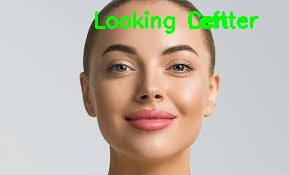

 Observation: Balanced Gaze Behavior

 Result for pic2.jpg:


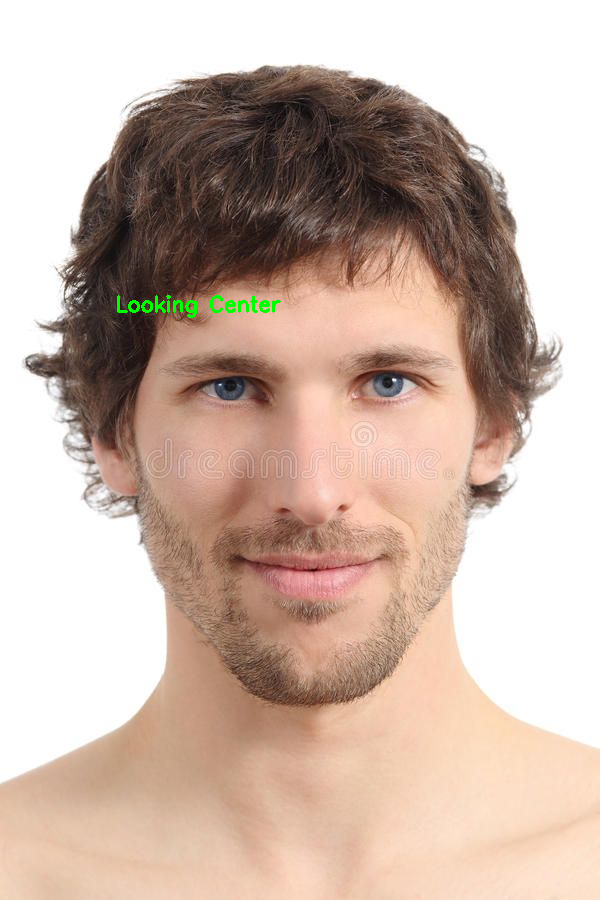

 Observation: Neutral or Engaged Gaze Behavior

 Result for pic3.jpg:


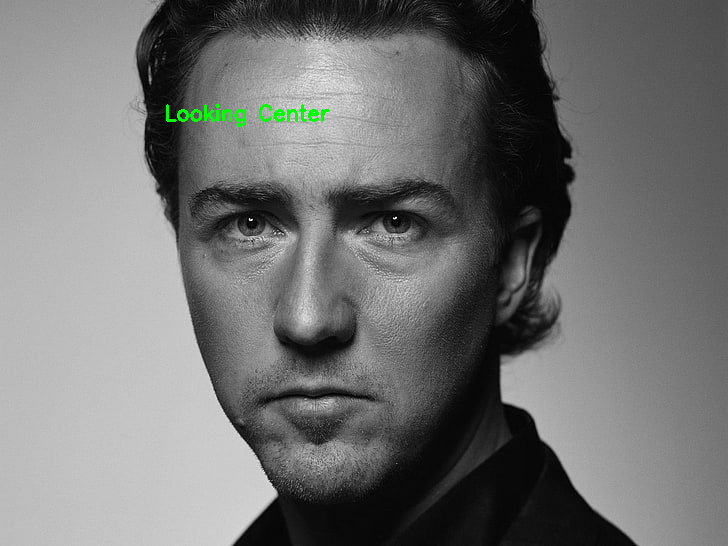

 Observation: Neutral or Engaged Gaze Behavior


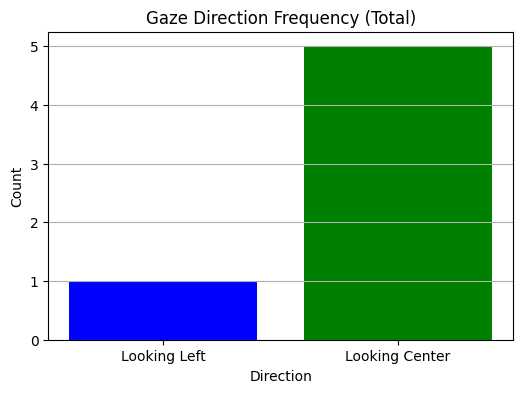

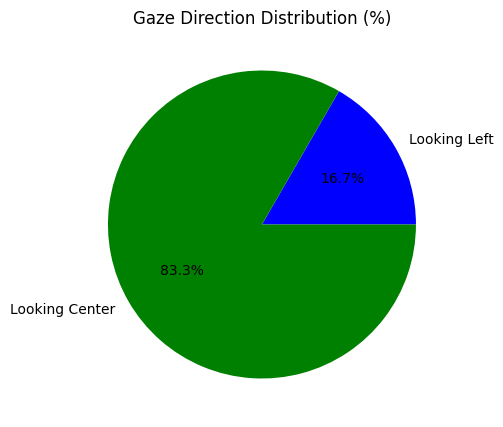

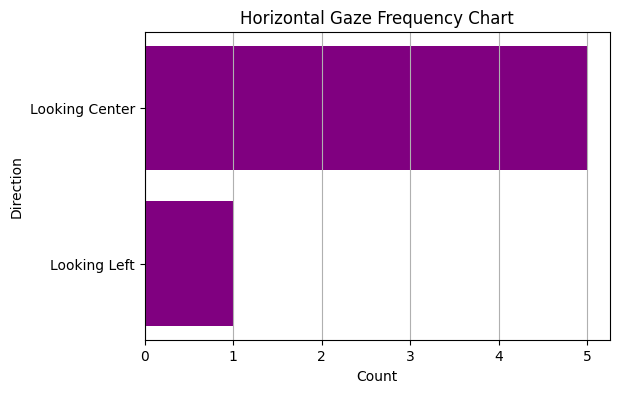

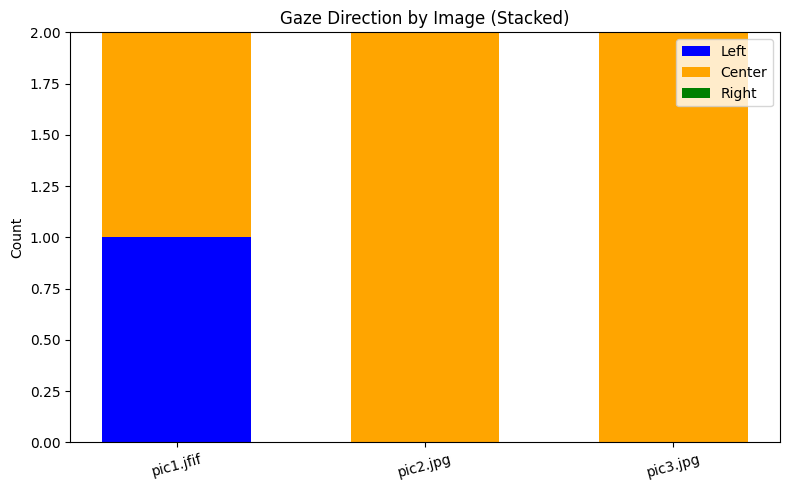

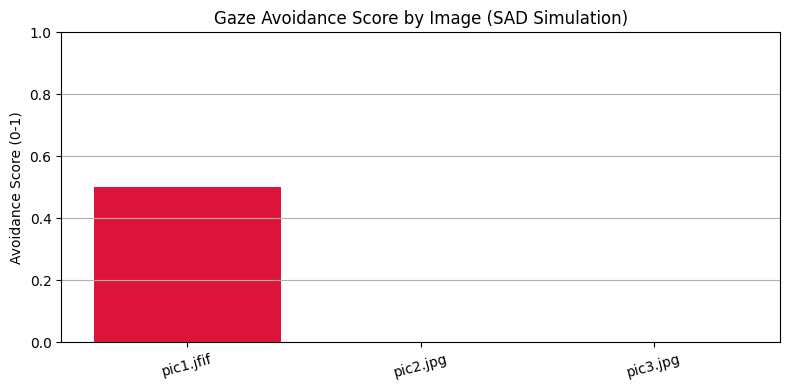

In [3]:

import cv2
import dlib
from imutils import face_utils
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# Load face detector and landmark predictor
predictor_path = "/content/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# Eye landmark points
left_eye_points = [36, 37, 38, 39, 40, 41]
right_eye_points = [42, 43, 44, 45, 46, 47]

def get_eye_region(landmarks, eye_points):
    points = [landmarks.part(point) for point in eye_points]
    region = np.array([(point.x, point.y) for point in points], np.int32)
    return region

# Image files
image_files = ["pic1.jfif", "pic2.jpg", "pic3.jpg"]

# Store total direction results
total_directions = []
per_image_directions = defaultdict(list)

# === Process Each Image ===
for image_file in image_files:
    frame = cv2.imread(image_file)
    if frame is None:
        print(f" Could not load image: {image_file}")
        continue

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)

        for eye_points in [left_eye_points, right_eye_points]:
            region = get_eye_region(landmarks, eye_points)
            min_x = np.min(region[:, 0])
            max_x = np.max(region[:, 0])
            min_y = np.min(region[:, 1])
            max_y = np.max(region[:, 1])

            eye = gray[min_y:max_y, min_x:max_x]
            eye = cv2.resize(eye, (100, 50))
            _, threshold_eye = cv2.threshold(eye, 70, 255, cv2.THRESH_BINARY_INV)
            moments = cv2.moments(threshold_eye)

            if moments['m00'] != 0:
                cx = int(moments['m10'] / moments['m00'])

                if cx < 30:
                    direction = "Looking Left"
                elif cx > 70:
                    direction = "Looking Right"
                else:
                    direction = "Looking Center"

                total_directions.append(direction)
                per_image_directions[image_file].append(direction)

                cv2.putText(frame, direction, (face.left(), face.top() - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Display image
    print(f"\n Result for {image_file}:")
    cv2_imshow(frame)

    # === SAD Behavior Inference ===
    directions = per_image_directions[image_file]
    counts = Counter(directions)
    left = counts.get("Looking Left", 0)
    right = counts.get("Looking Right", 0)
    center = counts.get("Looking Center", 0)
    total = left + right + center

    if total > 0:
        center_ratio = center / total
        if center_ratio < 0.3:
            print("Observation: Possible Avoidant Behavior (Low Eye Contact)")
        elif center_ratio > 0.6:
            print(" Observation: Neutral or Engaged Gaze Behavior")
        else:
            print(" Observation: Balanced Gaze Behavior")

# === Plot 1: Total Gaze Direction Counts ===
direction_counts = Counter(total_directions)
plt.figure(figsize=(6, 4))
plt.bar(direction_counts.keys(), direction_counts.values(), color=['blue', 'green', 'orange'])
plt.title("Gaze Direction Frequency (Total)")
plt.xlabel("Direction")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

# === Plot 2: Pie Chart ===
plt.figure(figsize=(5, 5))
plt.pie(direction_counts.values(), labels=direction_counts.keys(),
        autopct='%1.1f%%', colors=['blue', 'green', 'orange'])
plt.title("Gaze Direction Distribution (%)")
plt.show()

# === Plot 3: Horizontal Bar Chart ===
plt.figure(figsize=(6, 4))
plt.barh(list(direction_counts.keys()), list(direction_counts.values()), color='purple')
plt.xlabel("Count")
plt.ylabel("Direction")
plt.title("Horizontal Gaze Frequency Chart")
plt.grid(axis='x')
plt.show()

# === Plot 4: Stacked Bar Chart (per image) ===
image_labels = []
left_counts = []
center_counts = []
right_counts = []

for img, directions in per_image_directions.items():
    c = Counter(directions)
    image_labels.append(img)
    left_counts.append(c.get("Looking Left", 0))
    center_counts.append(c.get("Looking Center", 0))
    right_counts.append(c.get("Looking Right", 0))

x = np.arange(len(image_labels))
bar_width = 0.6

plt.figure(figsize=(8, 5))
plt.bar(x, left_counts, bar_width, label='Left', color='blue')
plt.bar(x, center_counts, bar_width, bottom=left_counts, label='Center', color='orange')
bottoms = [l + c for l, c in zip(left_counts, center_counts)]
plt.bar(x, right_counts, bar_width, bottom=bottoms, label='Right', color='green')

plt.xticks(x, image_labels, rotation=15)
plt.ylabel('Count')
plt.title('Gaze Direction by Image (Stacked)')
plt.legend()
plt.tight_layout()
plt.show()

# === Plot 5: Gaze Avoidance Score (SAD Simulation) ===
avoidance_scores = [
    (Counter(per_image_directions[img]).get("Looking Left", 0) +
     Counter(per_image_directions[img]).get("Looking Right", 0)) /
    max(1, sum(Counter(per_image_directions[img]).values()))
    for img in image_labels
]

plt.figure(figsize=(8, 4))
plt.bar(image_labels, avoidance_scores, color='crimson')
plt.ylabel("Avoidance Score (0-1)")
plt.title("Gaze Avoidance Score by Image (SAD Simulation)")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()